#### Mempersiapkan Library

In [1]:
import pandas as pd
import numpy as np
import re
import csv
from string import punctuation
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
import pickle

In [2]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 01AA-1B3B

 Directory of c:\Users\Cupiz\Documents\GitHub\Sentiment-Analyst\Train

06/09/2023  02:50    <DIR>          .
06/09/2023  02:50    <DIR>          ..
06/09/2023  02:13            27.908 model_NN.ipynb
06/09/2023  02:13            30.492 modelCNN.ipynb
06/09/2023  02:13            30.417 modelLSTM.ipynb
11/08/2023  19:26            13.794 modelRegressi.ipynb
               4 File(s)        102.611 bytes
               2 Dir(s)  346.409.230.336 bytes free


#### Mempersiapkan Dataset

In [3]:
tsv_file_path = "../train_preprocess.tsv.txt"

data_text = []
label = []

with open(tsv_file_path, encoding='utf-8') as tsvfile:
    tsv_reader = csv.reader(tsvfile, delimiter='\t')
    for row in tsv_reader:
        data_text.append(row[0])
        label.append(row[1])

df = pd.DataFrame({'data_text': data_text, 'label': label})

In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(7040, 2)
(2200, 2)
(1760, 2)


In [6]:
print('Komposisi Label train_data:')
print(train_data['label'].value_counts())

print('Komposisi Label test_data:')
print(test_data['label'].value_counts())

print('Komposisi Label val_data:')
print(val_data['label'].value_counts())

Komposisi Label train_data:
positive    4134
negative    2185
neutral      721
Name: label, dtype: int64
Komposisi Label test_data:
positive    1272
negative     688
neutral      240
Name: label, dtype: int64
Komposisi Label val_data:
positive    1010
negative     563
neutral      187
Name: label, dtype: int64


#### Normalisasi Text

In [7]:
def lowercasing(paragraph):
    return paragraph.lower()

In [8]:
def menghilangkan_tandabaca(paragraph):
    new_paragraph = re.sub(fr'[{punctuation}]', r'', paragraph)
    return new_paragraph

In [9]:
def text_normalization(paragraph):
    paragraph = lowercasing(paragraph)
    paragraph = menghilangkan_tandabaca(paragraph)
    paragraph = re.sub(r"[ ]+",r' ',paragraph)
    return paragraph

In [10]:
train_data['data_text'] = train_data['data_text'].apply(lambda x: text_normalization(x))
test_data['data_text'] = test_data['data_text'].apply(lambda x: text_normalization(x))
val_data['data_text'] = val_data['data_text'].apply(lambda x: text_normalization(x))

#### Training Model

In [11]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [12]:
tokenizer.fit_on_texts(train_data['data_text'])

In [13]:
train_data_tf = tokenizer.texts_to_sequences(train_data['data_text'])
test_data_tf = tokenizer.texts_to_sequences(test_data['data_text'])
val_data_tf = tokenizer.texts_to_sequences(val_data['data_text'])

In [14]:
train_data['data_text']

4057     indihome gangguan terus bayar nya saja mahal t...
7811     tempat pemandangan nya luar biasa dan pelayana...
5046     bagaimana kalau netizen pada patungan menyewa ...
7404                                           tidak sehat
8055     ulah sendiri kok gubernur yang disalahkan dasa...
                               ...                        
10959                  saya cemburu tapi tidak bisa apaapa
3997     bubarkan saja dpr rakyat tidak butuh diwakili ...
4118     steak di sini selalu membuat ketagihan menu ke...
5646                                      adit kayak tarik
10675    restoran sumoamg padang dago adalah palung pop...
Name: data_text, Length: 7040, dtype: object

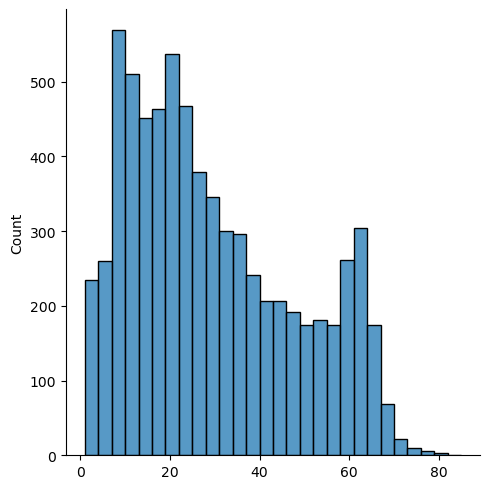

In [15]:
sns.displot([len(x) for x in train_data_tf])

In [16]:
max_len = int(np.quantile([len(x) for x in train_data_tf], 0.9))

In [17]:
max_len

59

In [18]:
train_padded = pad_sequences(sequences = train_data_tf, padding='post', maxlen=max_len)
test_padded = pad_sequences(sequences = test_data_tf, padding='post', maxlen=max_len)
val_padded = pad_sequences(sequences = val_data_tf, padding='post', maxlen=max_len)

In [19]:
print(train_padded.shape)
print(test_padded.shape)
print(val_padded.shape)

(7040, 59)
(2200, 59)
(1760, 59)


In [20]:
onehot = OneHotEncoder()

In [21]:
onehot.fit_transform(train_data[['label']])

<7040x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7040 stored elements in Compressed Sparse Row format>

In [22]:
train_labels = onehot.fit_transform(train_data[['label']]).toarray()

#### Model Testing and Evaluation

In [23]:
model = Sequential()

In [24]:
max_features = len(tokenizer.index_word)
batch_size=16
output_dim = 64
input_len = max_len

In [25]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                           output_dim=output_dim,
                           input_length=input_len))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
maximum_index_training = int(np.floor(train_padded.shape[0]/batch_size)*batch_size)
train = model.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_size, 
          epochs=20, 
          shuffle=False)

Epoch 1/20
440/440 [==============================] - 23s 47ms/step - loss: 0.8808 - accuracy: 0.6178
Epoch 2/20
440/440 [==============================] - 22s 50ms/step - loss: 0.7727 - accuracy: 0.6888
Epoch 3/20
440/440 [==============================] - 22s 49ms/step - loss: 0.6703 - accuracy: 0.7345
Epoch 4/20
440/440 [==============================] - 22s 50ms/step - loss: 0.5526 - accuracy: 0.7886
Epoch 5/20
440/440 [==============================] - 22s 51ms/step - loss: 0.4870 - accuracy: 0.8119
Epoch 6/20
440/440 [==============================] - 21s 49ms/step - loss: 0.4252 - accuracy: 0.8330
Epoch 7/20
440/440 [==============================] - 23s 52ms/step - loss: 0.3739 - accuracy: 0.8545
Epoch 8/20
440/440 [==============================] - 21s 49ms/step - loss: 0.2906 - accuracy: 0.8756
Epoch 9/20
440/440 [==============================] - 22s 50ms/step - loss: 0.1726 - accuracy: 0.9406
Epoch 10/20
440/440 [==============================] - 25s 56ms/step - loss: 0.104

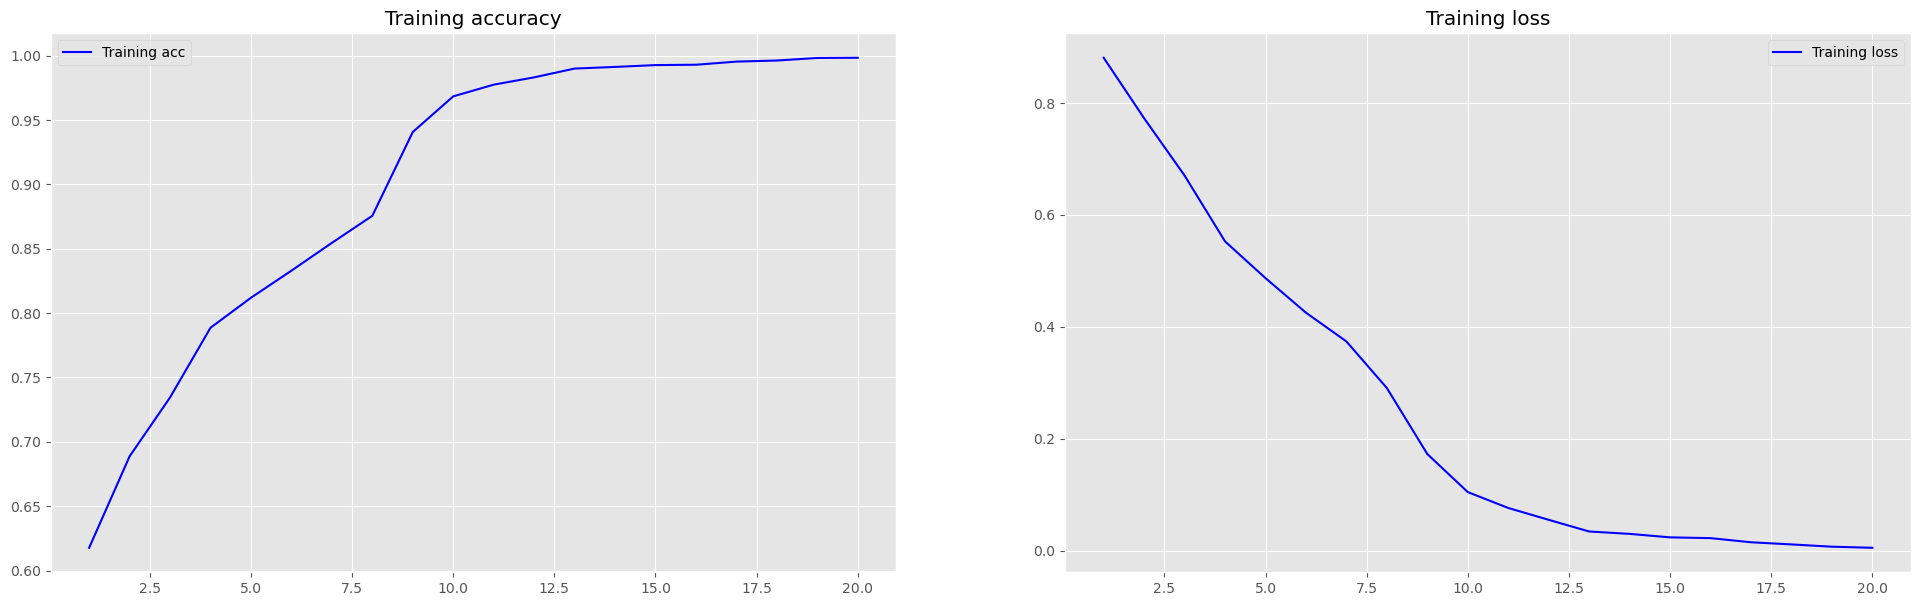

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_train(train):
    acc = train.history['accuracy']
    loss = train.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

%matplotlib inline
plot_train(train)

In [33]:
y_pred = model.predict(val_padded,batch_size=1)

1760/1760 [==============================] - 7s 4ms/step


In [34]:
y_pred = onehot.inverse_transform(y_pred).reshape(-1)

In [48]:
pred = accuracy_score(y_pred=y_pred, y_true=val_data['label'])
print(pred)
print('{:.0%}'.format(pred))

0.8272727272727273
83%


In [39]:
pickle.dump(model, open('../Model/model_LSTM.h5','wb'))